In [1]:
import pandas as pd 
import pydot
import numpy as np 
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings
import random
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from mlxtend.plotting import plot_confusion_matrix



In [2]:
os.listdir('D:\HAM')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('D:\HAM\HAM10000_metadata.csv')

size = (64, 64)

In [5]:
base_dir = 'D:\HAM'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [6]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

In [7]:
df = df[['dx', 'image']]

In [8]:
df.head()

,dx,image
0,bkl,"[[[0.7490196078431373, 0.596078431372549, 0.76..."
1,bkl,"[[[0.09019607843137255, 0.050980392156862744, ..."
2,bkl,"[[[0.7294117647058823, 0.5058823529411764, 0.5..."
3,bkl,"[[[0.09411764705882353, 0.043137254901960784, ..."
4,bkl,"[[[0.5450980392156862, 0.37254901960784315, 0...."


In [9]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

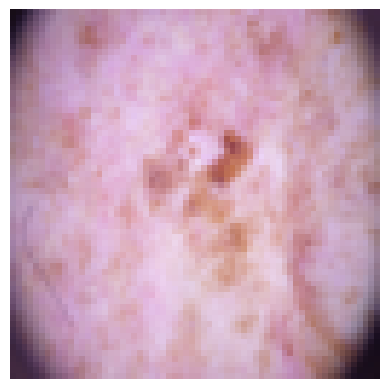

In [10]:
arr = df.iloc[1]['image']
#Image.fromarray(arr)
plt.imshow(arr)
plt.axis('off') 
plt.show()

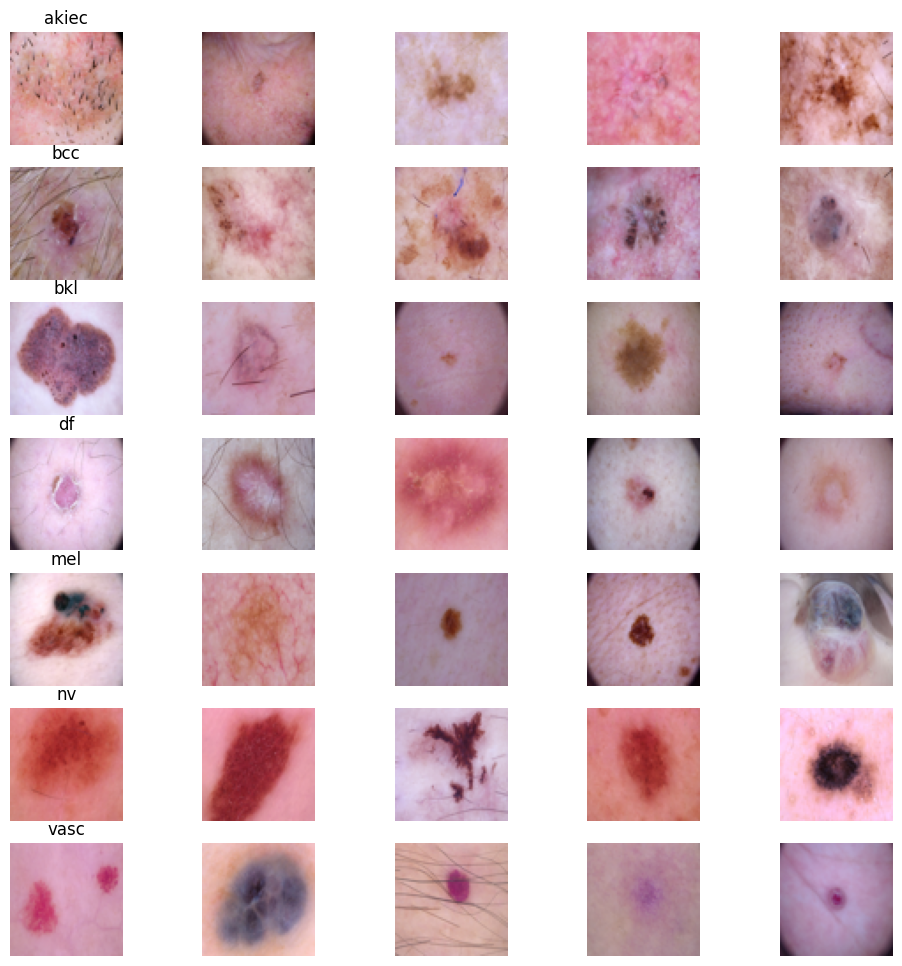

In [11]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [12]:
counts = pd.DataFrame(df['dx'].value_counts()).reset_index()
counts

,dx,count
0,nv,6705
1,mel,1113
2,bkl,1099
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


In [13]:
df_df = df[df['dx'] == 'df']
vasc_df = df[df['dx'] == 'vasc']
akiec_df = df[df['dx'] == 'akiec']
bcc_df = df[df['dx'] == 'bcc']
bkl_df = df[df['dx'] == 'bkl']
mel_df = df[df['dx'] == 'mel']

In [14]:
#Аугментация данных

In [14]:
def aug_brightness(img_arr):    
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_contrast(img_arr):    
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_flip_left_right(img_arr):    
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_flip_up_down(img_arr):    
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_hue(img_arr):    
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_saturation(img_arr):    
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [15]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [16]:
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))
    
    new_images = pd.DataFrame({'dx': dx, 'image': new_images})
    
    return all_indices, new_images

In [17]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', 700)

702/700


In [18]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', 700)

702/700


In [19]:
akiec_images = akiec_df['image']
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', 1000)

1002/1000


In [20]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', 1200)

1200/1200


In [21]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [22]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [23]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [24]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,2517
2,bkl,2503
3,bcc,1714
4,akiec,1329
5,vasc,844
6,df,817


In [25]:
aug_df.shape

(16429, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


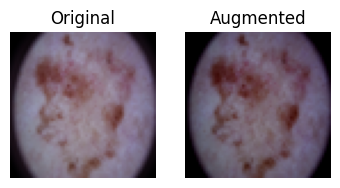

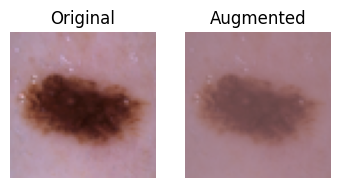

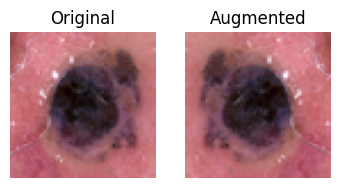

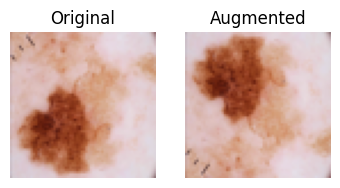

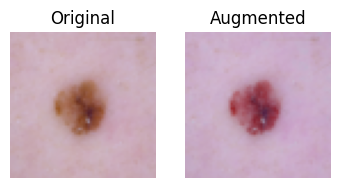

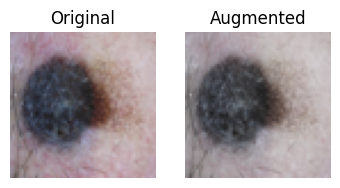

In [26]:
for i in range(12, 18):
    plt.subplot(1, 3, 1) 
    plt.imshow(mel_df['image'].iloc[mel_indices[i]])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2) 
    plt.imshow(mel_new_images['image'].iloc[i])
    plt.title('Augmented')
    plt.axis('off')
    
    plt.show()

In [27]:
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [28]:
x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42, shuffle=True)

In [ ]:
#Создание модели

In [33]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization() ,
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform')
])


model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:

early_stopping = EarlyStopping(monitor='val_loss', patience=7)

history = model.fit(x_train, y_train, epochs=50, batch_size=8, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 198s 117ms/step - accuracy: 0.3124 - loss: 2.4460 - val_accuracy: 0.4349 - val_loss: 2.1758
Epoch 2/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 250s 152ms/step - accuracy: 0.4313 - loss: 1.7837 - val_accuracy: 0.4166 - val_loss: 1.9267
Epoch 3/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 257s 156ms/step - accuracy: 0.4699 - loss: 1.6165 - val_accuracy: 0.5076 - val_loss: 1.5292
Epoch 4/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 246s 150ms/step - accuracy: 0.4931 - loss: 1.4926 - val_accuracy: 0.5429 - val_loss: 1.5708
Epoch 5/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 246s 150ms/step - accuracy: 0.5009 - loss: 1.3960 - val_accuracy: 0.4951 - val_loss: 1.6157
Epoch 6/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 244s 149ms/step - accuracy: 0.5229 - loss: 1.2949 - val_accuracy: 0.5396 - val_loss: 1.4048
Epoch 7/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 243s 148ms/step - accuracy: 0.5475 - loss: 1.2408 - val_accuracy: 0.5736 - val_loss: 1.2734
Epoch 8/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 221s 134ms/step - ac

In [156]:
model.save('D:\d\model/model.h5')

In [35]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8091 - loss: 0.6167
Test Accuracy: 0.8164942264556885
Test Loss: 0.5665448307991028


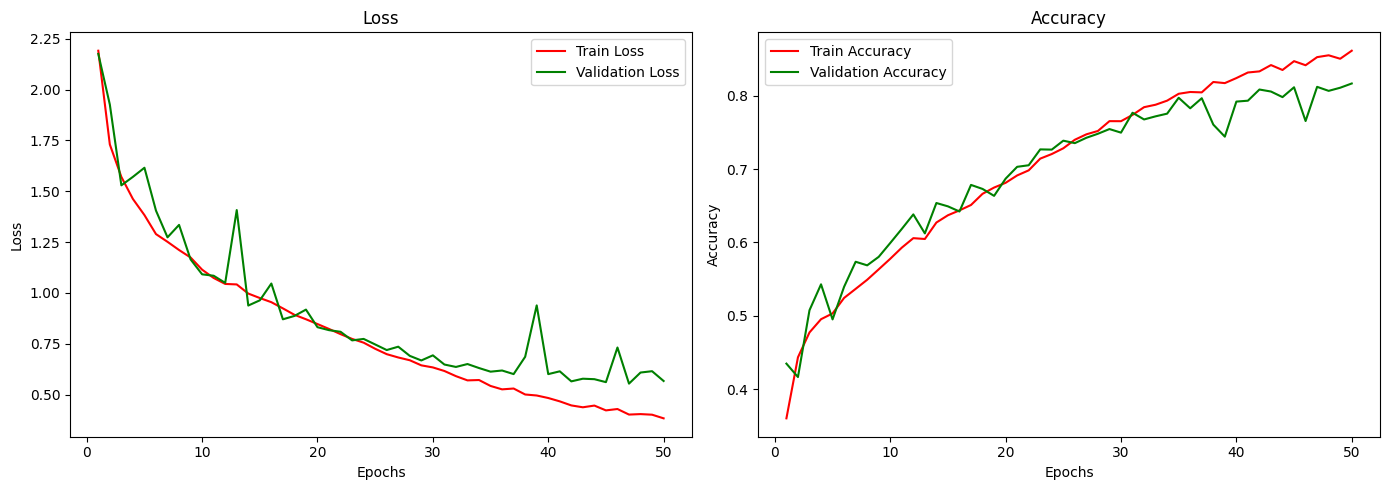

In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

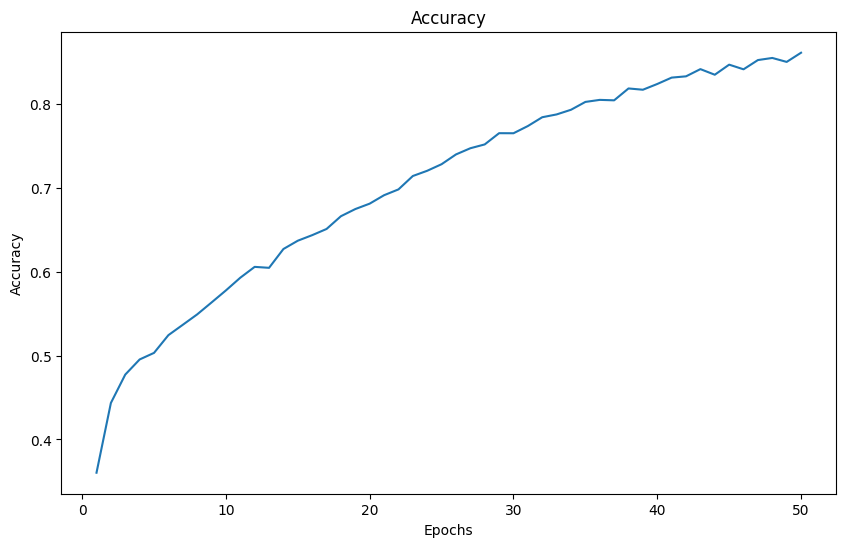

In [37]:
tr_acc = history.history['accuracy']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

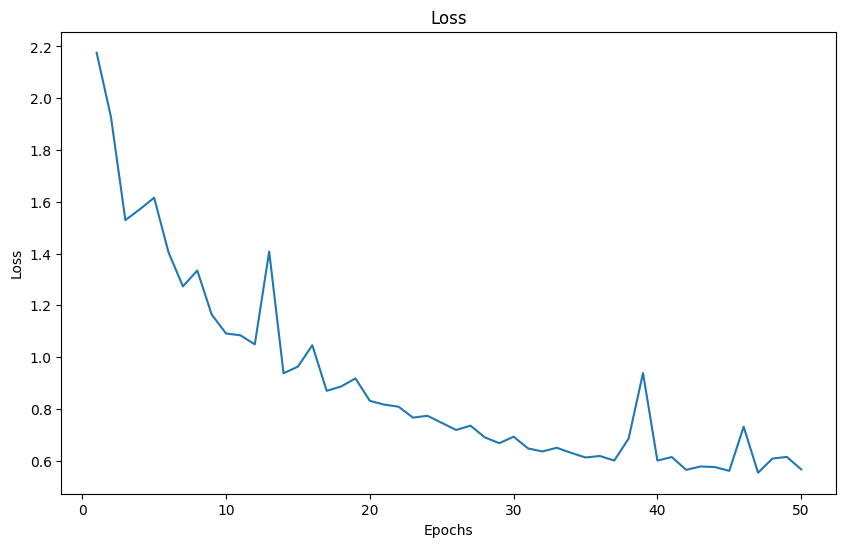

In [38]:
tr_acc = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=50)

In [39]:
predictions = model.predict(x_test)

103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


In [40]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
cm

array([[ 214,   24,   15,    1,   10,    5,    0],
       [  15,  318,   10,    3,    3,    7,    2],
       [  18,   18,  357,    5,   39,   72,    0],
       [   4,    4,    0,  135,    0,    4,    0],
       [  16,    9,   51,    4,  295,  120,    6],
       [   7,   30,   47,   10,   42, 1196,    1],
       [   1,    0,    0,    0,    0,    0,  168]], dtype=int64)

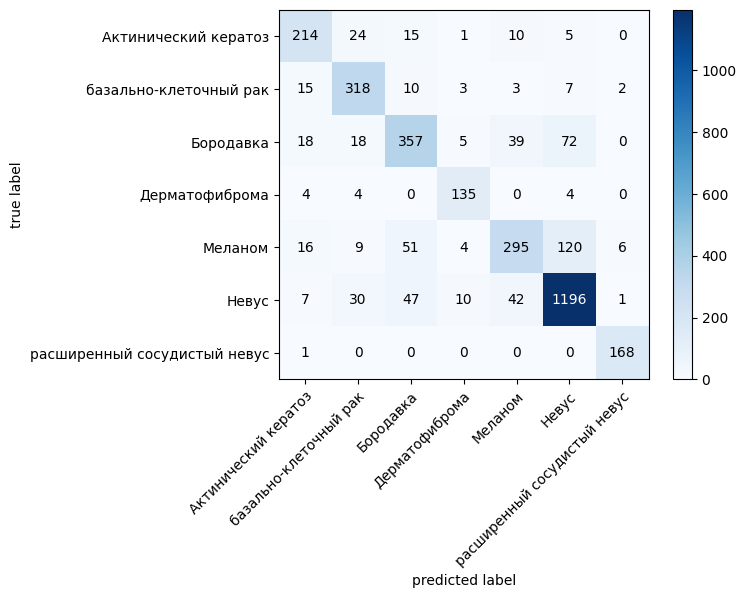

In [41]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


translation_dict = {
    'akiec': 'Актинический кератоз',
    'bcc': 'базально-клеточный рак',
    'bkl': 'Бородавка',
    'df': 'Дерматофиброма',
    'mel': 'Меланом',
    'nv': 'Невус',
    'vasc': 'расширенный сосудистый невус'
}


translated_class_names = [translation_dict.get(name, name) for name in cm_plot_labels]

fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=translated_class_names, colorbar=True)
plt.show()

In [42]:
import pandas as pd
from sklearn.metrics import classification_report


translation_dict = {
    'akiec': 'актинический кератоз',
    'bcc': 'базально-клеточный рак',
    'bkl': 'бородавка',
    'df': 'дерматофиброма',
    'mel': 'меланома',
    'nv': 'невус',
    'vasc': 'расширенный сосудистый невус',
}


translated_target_names = [translation_dict.get(name, name) for name in cm_plot_labels]


report1 = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=translated_target_names, output_dict=True)


df_classification_report = pd.DataFrame(report1).transpose()
df_classification_report.drop(["accuracy", "macro avg", "weighted avg"], inplace=True)
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report["precision"] = df_classification_report["precision"].map(lambda x: round(x, 3))
df_classification_report["recall"] = df_classification_report["recall"].map(lambda x: round(x, 3))
df_classification_report["f1-score"] = df_classification_report["f1-score"].map(lambda x: round(x, 3))
df_classification_report["support"] = df_classification_report["support"].map(int)

print(df_classification_report)

                              precision  recall  f1-score  support
расширенный сосудистый невус      0.949   0.994     0.971      169
дерматофиброма                    0.854   0.918     0.885      147
невус                             0.852   0.897     0.874     1333
базально-клеточный рак            0.789   0.888     0.836      358
актинический кератоз              0.778   0.796     0.787      269
бородавка                         0.744   0.701     0.722      509
меланома                          0.758   0.589     0.663      501


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


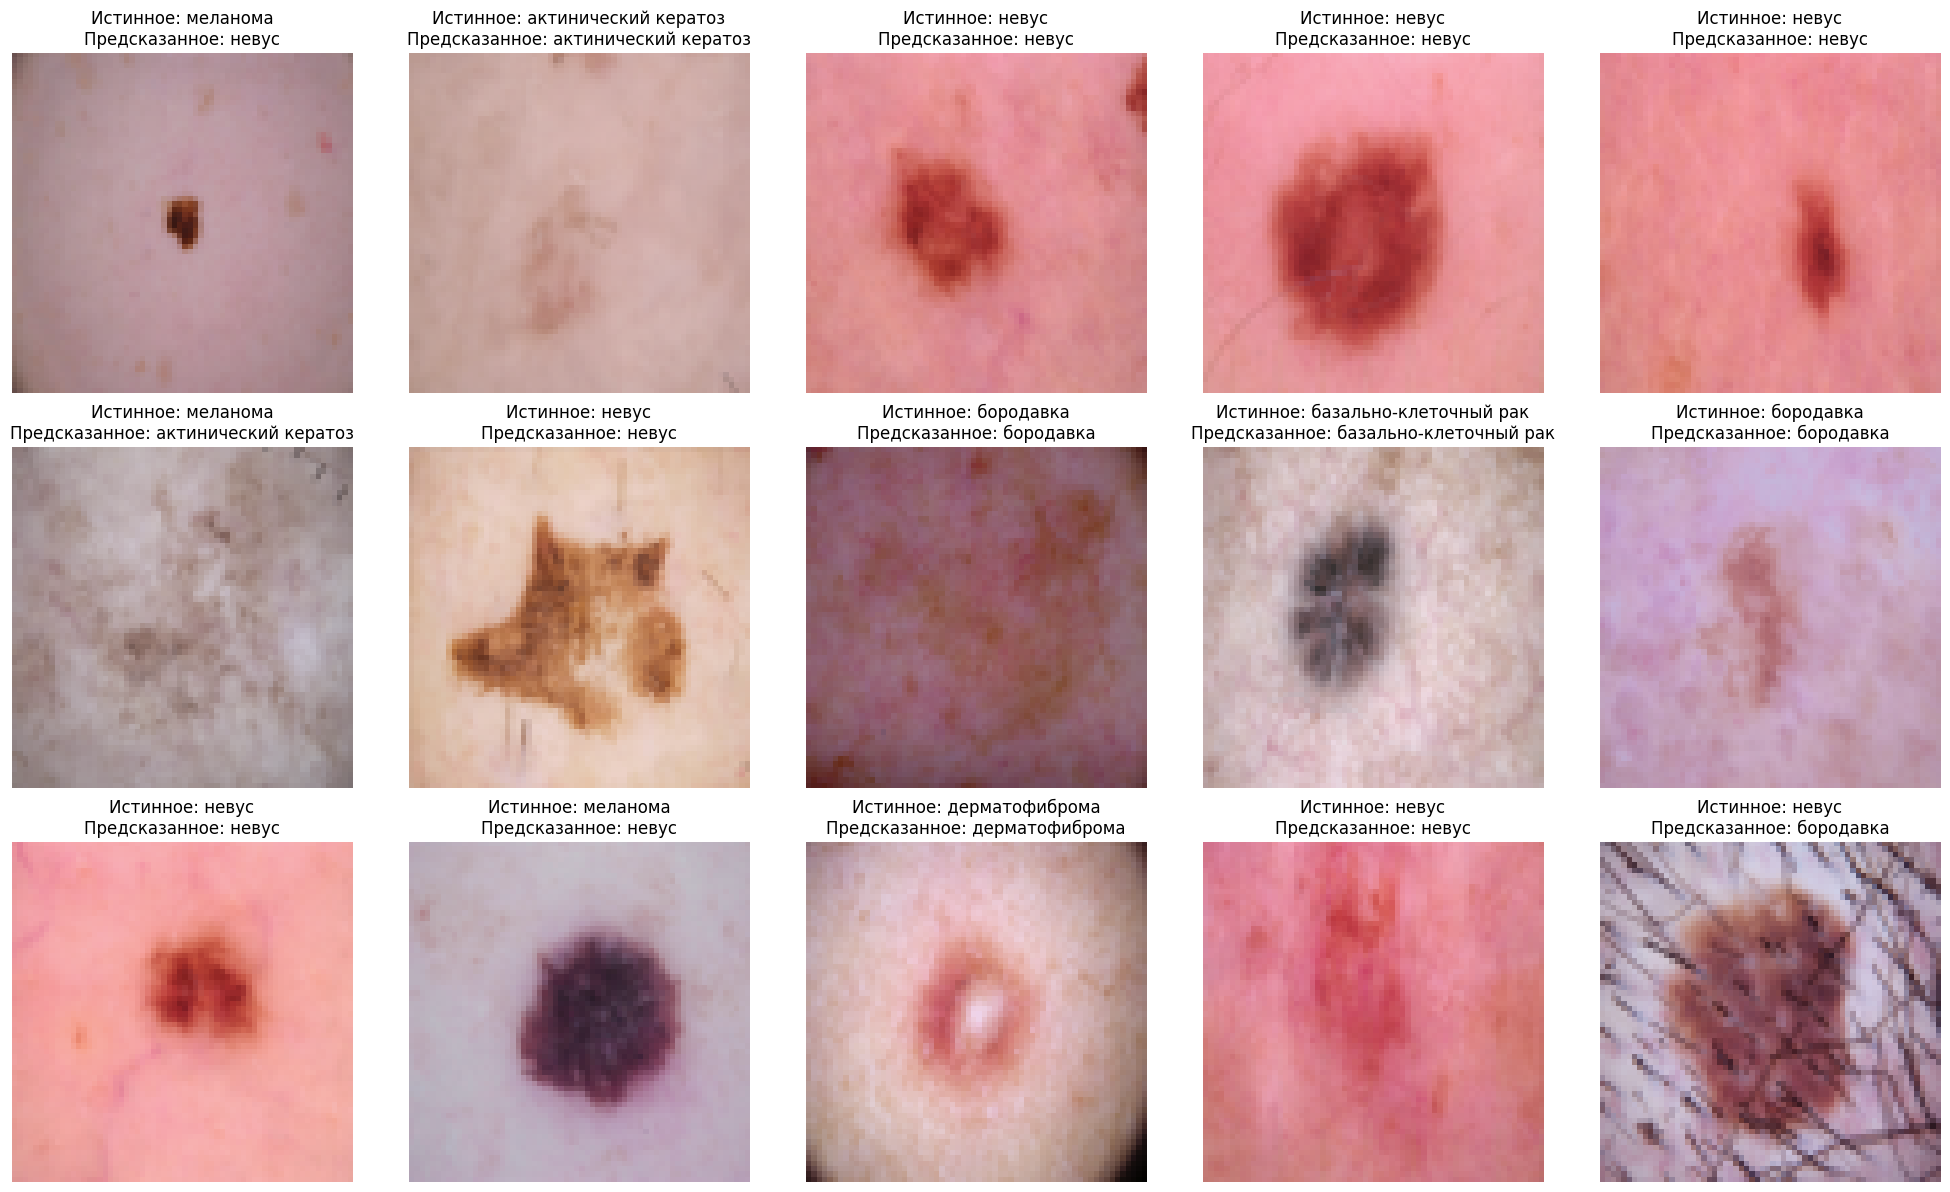

In [43]:

class_labels = {
    0: 'актинический кератоз',
    1: 'базально-клеточный рак',
    2: 'бородавка',
    3: 'дерматофиброма',
    4: 'меланома',
    5: 'невус',
    6: 'расширенный сосудистый невус'
}

def display_image_with_labels(ax, image, true_label_index, predicted_label_index):

    true_label_name = class_labels.get(true_label_index, "Неизвестная болезнь")
    predicted_label_name = class_labels.get(predicted_label_index, "Неизвестная болезнь")

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Истинное: {true_label_name}\nПредсказанное: {predicted_label_name}")
 
    if true_label_index == predicted_label_index:
        ax.set_xlabel(f"Соответствие: {true_label_name}", color='green')
    else:
        ax.set_xlabel(f"Несоответствие: Истинное-{true_label_name}\nПредсказанное-{predicted_label_name}", color='red')

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for ax in axes.flat:
    random_idx = random.randint(0, len(x_test) - 1)
    random_image = x_test[random_idx]
    true_label_index = y_test[random_idx].argmax()
    predicted_label_index = model.predict(np.expand_dims(random_image, axis=0)).argmax()
    display_image_with_labels(ax, random_image, true_label_index, predicted_label_index)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


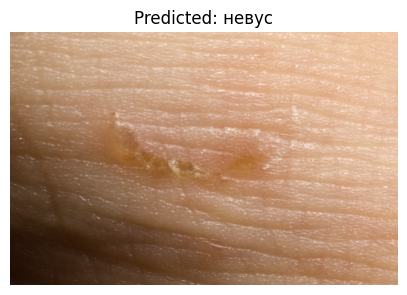

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


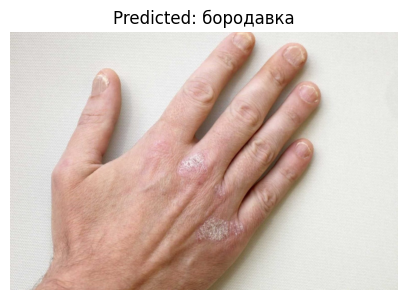

In [45]:





test_images_dir = 'D:\d\papla'

size = (64, 64)
class_labels_russian = ['актинический кератоз', 'базально-клеточный рак', 'бородавка', 'дерматофиброма', 'меланома', 'невус', 'расширенный сосудистый невус']

def load_and_preprocess_image(image_path, size):
    image = Image.open(image_path).resize(size)
    image = np.asarray(image) / 255.0  
    return image

def predict_image_class(model, image):
    image = np.expand_dims(image, axis=0)  
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)[0]
    return predicted_label

def display_image_with_prediction(original_image_path, model):
    
    original_image = Image.open(original_image_path)
    processed_image = load_and_preprocess_image(original_image_path, size)
    predicted_label = predict_image_class(model, processed_image)
    
    plt.figure(figsize=(5, 5))
    
    plt.imshow(original_image)
    plt.title(f"Predicted: {class_labels_russian[predicted_label]}")
    plt.axis('off')
    
    plt.show()

def iterate_and_predict_images(test_images_dir, model):
  
    for image_file in os.listdir(test_images_dir):
        image_path = os.path.join(test_images_dir, image_file)
        if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            display_image_with_prediction(image_path, model)


iterate_and_predict_images(test_images_dir, model)


In [29]:
#Использование готовой модели
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [30]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions1 = Dense(7, activation='softmax')(x)  

model1 = Model(inputs=base_model.input, outputs=predictions1)

In [31]:

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

history1 = model1.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.3965 - loss: 1.7674 - val_accuracy: 0.4057 - val_loss: 1.5057
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.4067 - loss: 1.5412 - val_accuracy: 0.4057 - val_loss: 1.7898
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 584s 1s/step - accuracy: 0.4206 - loss: 1.6078 - val_accuracy: 0.3886 - val_loss: 1.4691
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.3916 - loss: 1.5212 - val_accuracy: 0.4057 - val_loss: 1.4982
Epoch 5/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.4165 - loss: 1.4900 - val_accuracy: 0.4181 - val_loss: 1.4695
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.4291 - loss: 1.4177 - val_accuracy: 0.4744 - val_loss: 1.3159
Epoch 7/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 541s 1s/step - accuracy: 0.4784 - loss: 1.3073 - val_accuracy: 0.4985 - val_loss: 1.2681
Epoch 8/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.4868 - loss: 1.2773 - val_accu

In [63]:
from tensorflow.keras.models import load_model

# Загрузка модели
model1 = load_model('D:\\d\\model\\model1.h5')

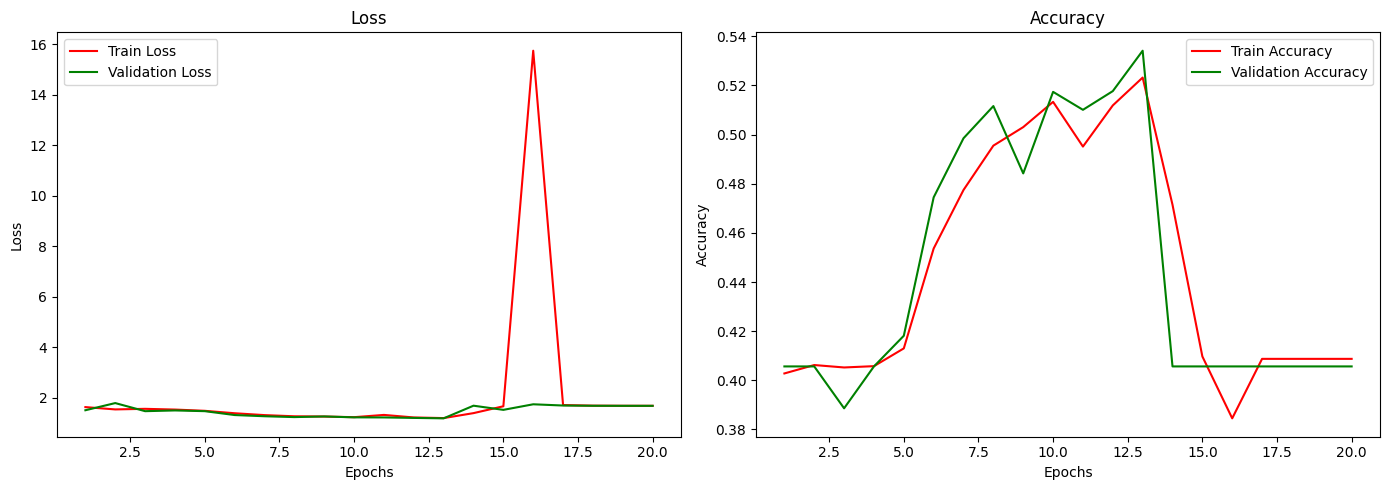

In [48]:
tr_acc1 = history1.history['accuracy']
tr_loss1 = history1.history['loss']
val_acc1 = history1.history['val_accuracy']
val_loss1 = history1.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss1, 'r', label='Train Loss')
plt.plot(epochs, val_loss1, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc1, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc1, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

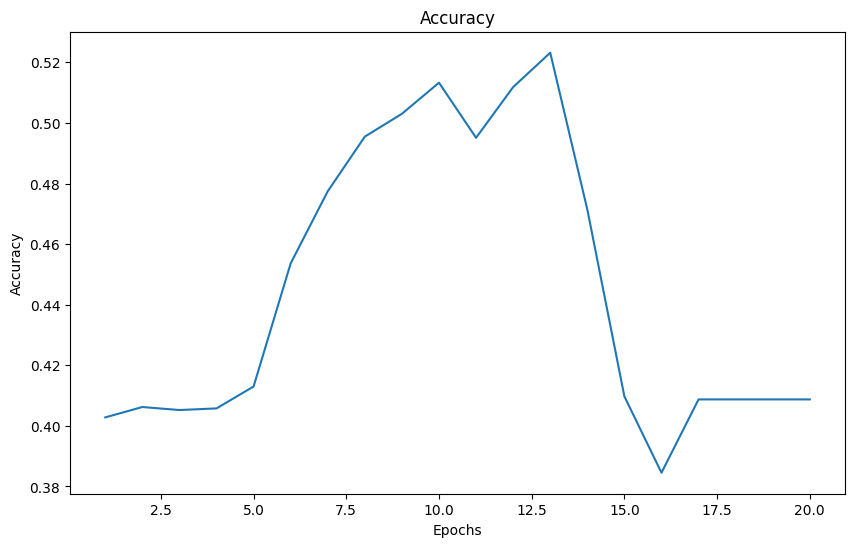

In [50]:
tr_acc1 = history1.history['accuracy']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

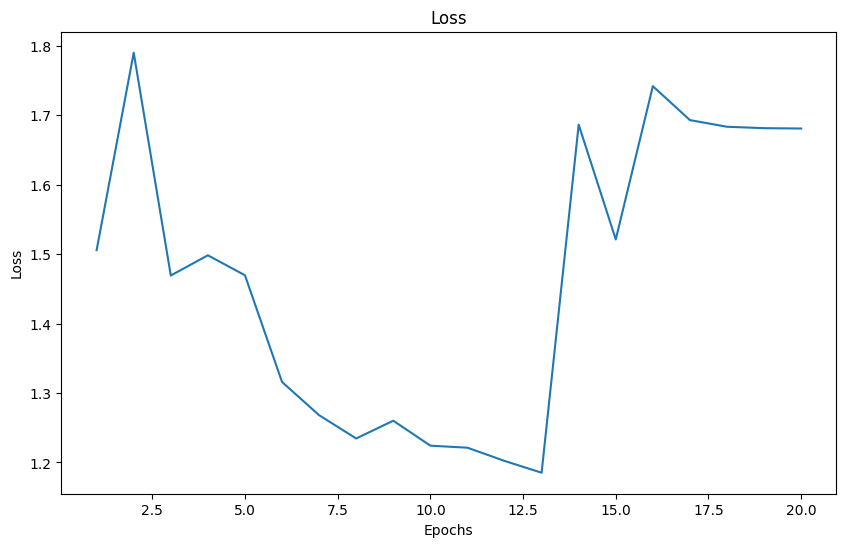

In [52]:
tr_acc1 = history1.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [64]:
predictions1 = model1.predict(x_test)

103/103 ━━━━━━━━━━━━━━━━━━━━ 28s 256ms/step


In [65]:
cm1 = confusion_matrix(y_test.argmax(axis=1), predictions1.argmax(axis=1))
cm1

array([[ 182,   39,   14,    7,   18,    8,    1],
       [  11,  292,   14,    3,   12,   19,    7],
       [  13,   25,  348,   10,   49,   62,    2],
       [   2,   13,    2,  120,    3,    5,    2],
       [   7,    7,   38,    6,  326,  117,    0],
       [   4,   13,   27,   11,   24, 1250,    4],
       [   1,   10,    2,    2,    6,    8,  140]], dtype=int64)

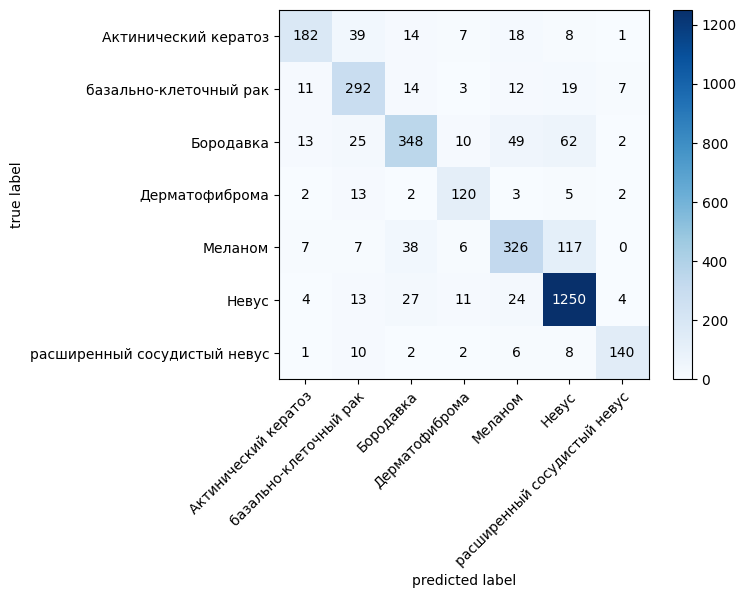

In [66]:



cm_plot_labels1 = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


translation_dict = {
    'akiec': 'Актинический кератоз',
    'bcc': 'базально-клеточный рак',
    'bkl': 'Бородавка',
    'df': 'Дерматофиброма',
    'mel': 'Меланом',
    'nv': 'Невус',
    'vasc': 'расширенный сосудистый невус'
}

translated_class_names = [translation_dict.get(name, name) for name in cm_plot_labels1]



fig, ax = plot_confusion_matrix(conf_mat=cm1, class_names=translated_class_names, colorbar=True)
plt.show()


In [67]:





translation_dict = {
    'akiec': 'актинический кератоз',
    'bcc': 'базально-клеточный рак',
    'bkl': 'бородавка',
    'df': 'дерматофиброма',
    'mel': 'меланома',
    'nv': 'невус',
    'vasc': 'расширенный сосудистый невус',
}

translated_target_names = [translation_dict.get(name, name) for name in cm_plot_labels1]

report1 = classification_report(y_test.argmax(axis=1), predictions1.argmax(axis=1), target_names=translated_target_names, output_dict=True)

df_classification_report = pd.DataFrame(report1).transpose()
df_classification_report.drop(["accuracy", "macro avg", "weighted avg"], inplace=True)
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report["precision"] = df_classification_report["precision"].map(lambda x: round(x, 3))
df_classification_report["recall"] = df_classification_report["recall"].map(lambda x: round(x, 3))
df_classification_report["f1-score"] = df_classification_report["f1-score"].map(lambda x: round(x, 3))
df_classification_report["support"] = df_classification_report["support"].map(int)

print(df_classification_report)


                              precision  recall  f1-score  support
невус                             0.851   0.938     0.892     1333
расширенный сосудистый невус      0.897   0.828     0.862      169
дерматофиброма                    0.755   0.816     0.784      147
базально-клеточный рак            0.732   0.816     0.771      358
актинический кератоз              0.827   0.677     0.744      269
бородавка                         0.782   0.684     0.730      509
меланома                          0.744   0.651     0.694      501


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


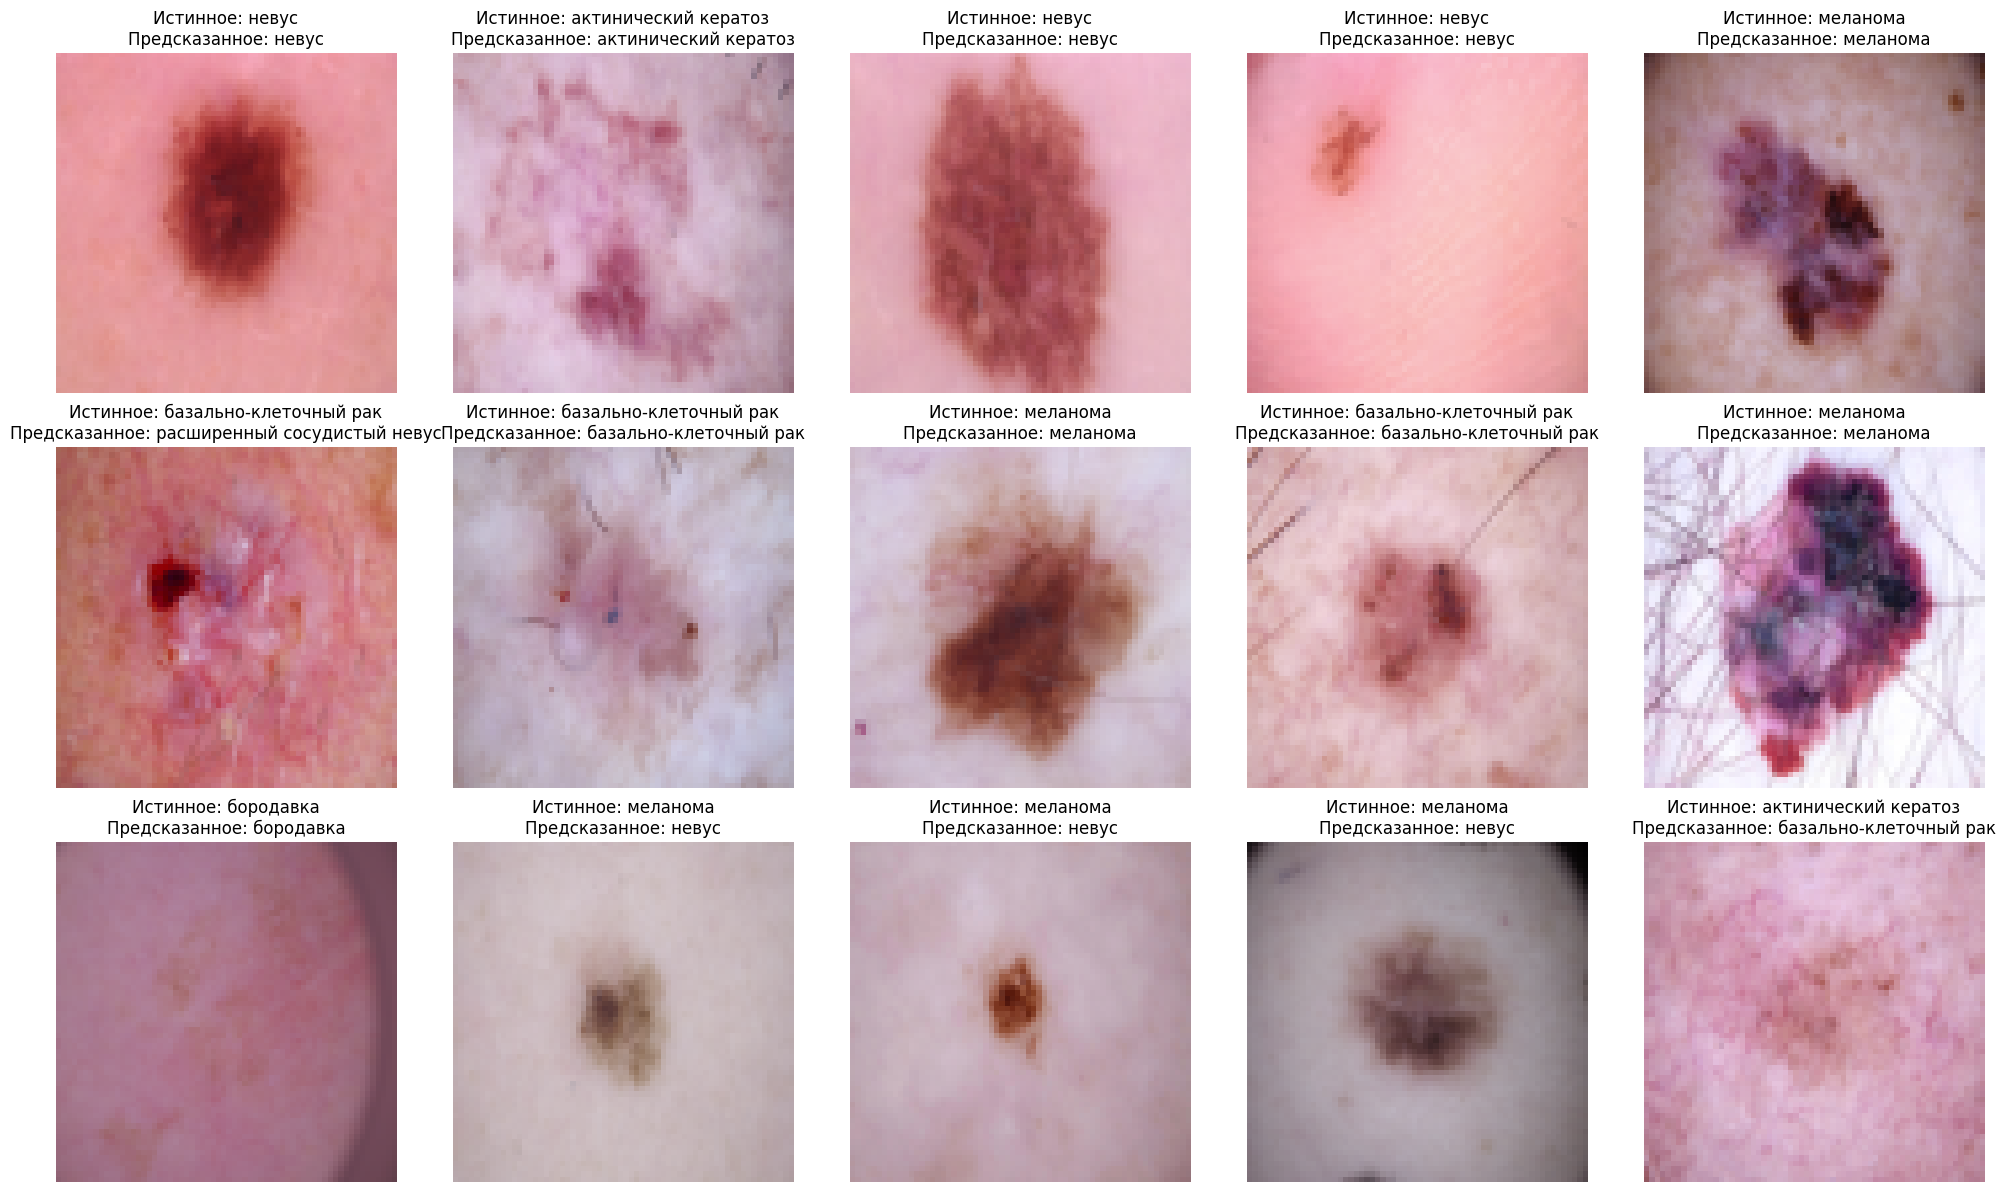

In [70]:

class_labels = {
    0: 'актинический кератоз',
    1: 'базально-клеточный рак',
    2: 'бородавка',
    3: 'дерматофиброма',
    4: 'меланома',
    5: 'невус',
    6: 'расширенный сосудистый невус'
}

def display_image_with_labels(ax, image, true_label_index, predicted_label_index):
    true_label_name = class_labels.get(true_label_index, "Неизвестная болезнь")
    predicted_label_name = class_labels.get(predicted_label_index, "Неизвестная болезнь")

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Истинное: {true_label_name}\nПредсказанное: {predicted_label_name}")
 
    if true_label_index == predicted_label_index:
        ax.set_xlabel(f"Соответствие: {true_label_name}", color='green')
    else:
        ax.set_xlabel(f"Несоответствие: Истинное-{true_label_name}\nПредсказанное-{predicted_label_name}", color='red')

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for ax in axes.flat:
    random_idx = random.randint(0, len(x_test) - 1)
    random_image = x_test[random_idx]
    true_label_index = y_test[random_idx].argmax()
    predicted_label_index = model1.predict(np.expand_dims(random_image, axis=0)).argmax()
    display_image_with_labels(ax, random_image, true_label_index, predicted_label_index)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


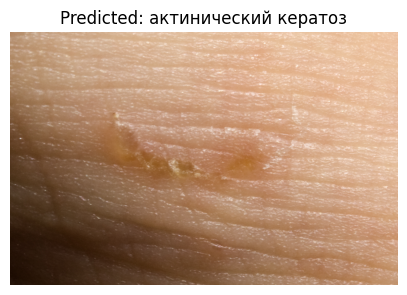

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


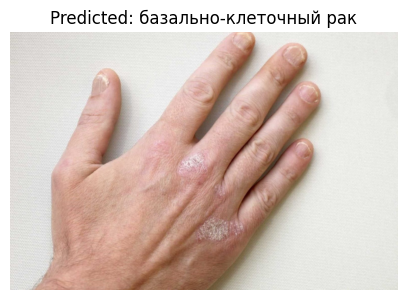

In [75]:



test_images_dir = 'D:\d\papla'


size = (64, 64)
class_labels_russian = ['актинический кератоз', 'базально-клеточный рак', 'бородавка', 'дерматофиброма', 'меланома', 'невус', 'расширенный сосудистый невус']

def load_and_preprocess_image(image_path, size):

    image = Image.open(image_path).resize(size)
    image = np.asarray(image) / 255.0 
    return image

def predict_image_class(model, image):

    image = np.expand_dims(image, axis=0)  
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)[0]
    return predicted_label

def display_image_with_prediction(original_image_path, model):
    
    original_image = Image.open(original_image_path)
    processed_image = load_and_preprocess_image(original_image_path, size)
    predicted_label = predict_image_class(model, processed_image)
    
    plt.figure(figsize=(5, 5))
    
   
    plt.imshow(original_image)
    plt.title(f"Predicted: {class_labels_russian[predicted_label]}")
    plt.axis('off')
    
    plt.show()

def iterate_and_predict_images(test_images_dir, model):
    
    for image_file in os.listdir(test_images_dir):
        image_path = os.path.join(test_images_dir, image_file)
        if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            display_image_with_prediction(image_path, model)


iterate_and_predict_images(test_images_dir, model1)
